# 🧠 BERT for Mental Health State Classification  

## 🔎 Project Overview  
The goal of this project is to classify mental health states based on short text statements. After preprocessing and balancing the dataset, the model predicts one of the following classes:

- **Normal**  
- **Depression**  
- **Suicidal**  
- **Anxiety**  
- **Stress**  
- **Bipolar**  
- **Personality disorder**

---

## ⚙️ Data Preprocessing  
- Dropped unnecessary columns (`Unnamed: 0`)  
- Removed null values using `dropna`  
- Performed text cleaning (lowercasing, removing special characters, stopword removal)  
- Balanced the dataset using **RandomOverSampler** from `imblearn`  
- Encoded class labels with **LabelEncoder**  
- Tokenized text with **BERT tokenizer**  

---

## 🤖 Model Building  
- Model: **BERT (bert-base-uncased)** fine-tuned for sequence classification  
- Used **Hugging Face Trainer** with training arguments (learning rate, epochs, batch size, etc.)  
- Evaluation performed with classification report and confusion matrix  

---

## 📊 Results  
The model provides predictions across all 7 classes and performance is evaluated with standard metrics (precision, recall, F1-score) and confusion matrix visualization.  
 

## Import Libraries

In [2]:
#%pip uninstall -y scikit-learn imbalanced-learn
#%pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0

import pandas as pd
import numpy as np
import transformers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

/home/kristina/.pyenv/versions/3.10.6/envs/stress_sense/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [4]:
df = pd.read_csv('/home/kristina/code/g0zzy/stress_sense/raw_data/CombinedData.csv', index_col=0)

In [5]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.head()

In [6]:
df.shape

(53043, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [8]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


## Handling Null Values

In [9]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
#df.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
df = df.sample(n=6000, random_state=42).reset_index(drop=True)

In [12]:
df

,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal
...,...,...
5995,What is around you right now? A photo? A comfo...,Depression
5996,I am tired. I am ready for everything to be ov...,Suicidal
5997,? What if I am at a friends party and a man wh...,Stress
5998,if it add any kind of info m almost the thing ...,Depression


## Data Preprocessing

### Text Cleaning

In [13]:
nltk.download('stopwords')
stopwordss = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    words = text.split()
    wordss = [word for word in words if word not in stopwordss]
    return " ".join(words)

df['statement'] = df['statement'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kristina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Resampling Data

In [14]:
df['status'].value_counts()

status
Normal                  1894
Depression              1730
Suicidal                1219
Anxiety                  429
Stress                   304
Bipolar                  293
Personality disorder     131
Name: count, dtype: int64

In [15]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X = df.drop(columns=['status'])
y = df['status']

X_resampled, y_resampled = ros.fit_resample(X,y)

df = pd.concat([X_resampled, y_resampled], axis=1)

print(df['status'].value_counts())

status
Normal                  1894
Bipolar                 1894
Depression              1894
Suicidal                1894
Stress                  1894
Personality disorder    1894
Anxiety                 1894
Name: count, dtype: int64


### Encoding

In [16]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])

## Splitting Data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['statement'], df['label'], test_size=0.2, random_state=42)

## Tokenization

In [18]:
tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased')

X_train_tokenize = tokenizer(list(X_train), padding=True, truncation=True, max_length=200)
X_test_tokenize = tokenizer(list(X_test), padding=True, truncation=True, max_length=200)

In [19]:
print(X_train_tokenize['input_ids'][1])       # first sentence input_ids
print(X_train_tokenize['attention_mask'][0] )  # first sentence attention_mask
print(X_train_tokenize['token_type_ids'][0])   # first sentence token_type_ids


[101, 2074, 10657, 2360, 2651, 2001, 2428, 7823, 1045, 3728, 2288, 5086, 2012, 1037, 3435, 2833, 4825, 1998, 2651, 2001, 2026, 2353, 2154, 1997, 2731, 2096, 2026, 10365, 2001, 2183, 2058, 2070, 2477, 1045, 2288, 2023, 3255, 4218, 2026, 3244, 6085, 2008, 2371, 2428, 4629, 2043, 1045, 8726, 1999, 1045, 2318, 16058, 6634, 6834, 5191, 2242, 2001, 3308, 1998, 1045, 2001, 6069, 6752, 2039, 2012, 2026, 2047, 3105, 2138, 1045, 2134, 2102, 2215, 2000, 2681, 2220, 2030, 2191, 3087, 4737, 1998, 1045, 2134, 2102, 2215, 2000, 3280, 1999, 1996, 5723, 4385, 1045, 2371, 1037, 6634, 2886, 3225, 2026, 3108, 2371, 3082, 1998, 1045, 2371, 2061, 6015, 1045, 2001, 6427, 2242, 2001, 3308, 2007, 2026, 8948, 2144, 2009, 2001, 2524, 2000, 7200, 2004, 2092, 1045, 3266, 2000, 2562, 2870, 2013, 2383, 1037, 6634, 2886, 1998, 3724, 2083, 2026, 5670, 2130, 2295, 1045, 2288, 1037, 2919, 14978, 2005, 1996, 2197, 3178, 1997, 2009, 1045, 2288, 2188, 9069, 10047, 2145, 6015, 2008, 2242, 2003, 3308, 2007, 2026, 8948, 2740,

In [20]:
train_dataset = Dataset.from_dict({
    'input_ids': X_train_tokenize['input_ids'],
    'attention_mask': X_train_tokenize['attention_mask'],
    'labels': list(y_train)
})

test_dataset = Dataset.from_dict({
    'input_ids': X_test_tokenize['input_ids'],
    'attention_mask': X_test_tokenize['attention_mask'],
    'labels': list(y_test)
})

## Model Building

In [21]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(le.classes_))
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)


In [23]:
import wandb
wandb.init(project="Mental Healt State", entity="shivamshukla8112005", mode="offline")

ModuleNotFoundError: No module named 'wandb'

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.072200,0.969654
2,0.345100,0.318570
3,0.247400,0.213883
4,0.095400,0.210123
5,0.077500,0.225651


TrainOutput(global_step=1660, training_loss=0.5064255246376417, metrics={'train_runtime': 45126.2875, 'train_samples_per_second': 1.175, 'train_steps_per_second': 0.037, 'total_flos': 5450549081100000.0, 'train_loss': 0.5064255246376417, 'epoch': 5.0})

## Evaluation

                      precision    recall  f1-score   support

             Anxiety       0.97      1.00      0.99       342
             Bipolar       0.99      1.00      0.99       397
          Depression       0.86      0.66      0.75       369
              Normal       0.96      0.94      0.95       401
Personality disorder       1.00      1.00      1.00       386
              Stress       0.97      1.00      0.98       361
            Suicidal       0.77      0.89      0.82       396

            accuracy                           0.93      2652
           macro avg       0.93      0.93      0.93      2652
        weighted avg       0.93      0.93      0.93      2652



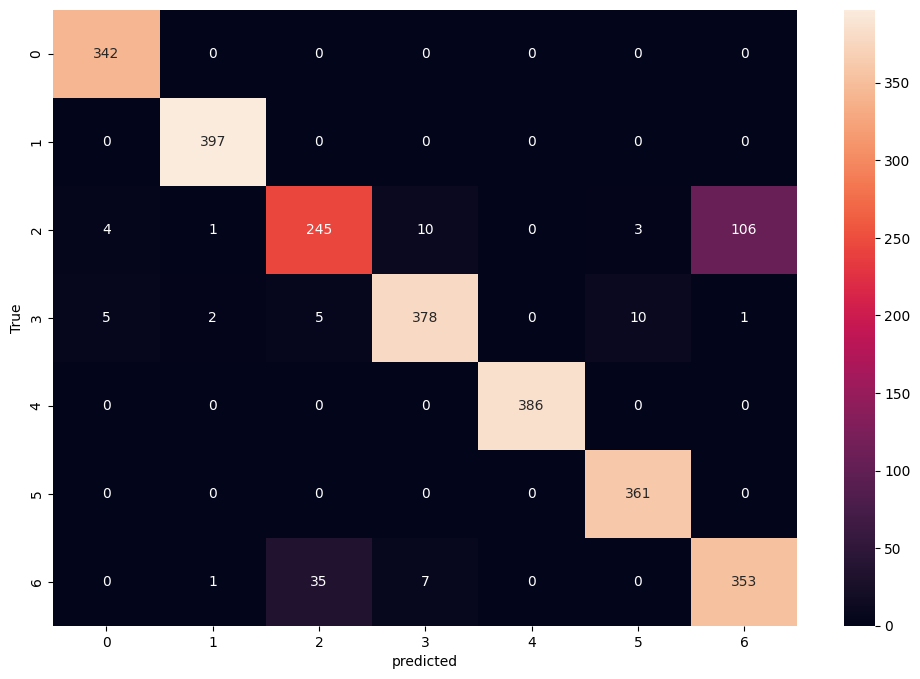

In [25]:
pred, labels, _ = trainer.predict(test_dataset)

predicted_labels = np.argmax(pred, axis=1)

print(classification_report(y_test, predicted_labels, target_names=le.classes_))

cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()